In [1]:
import os
import pandas as pd
import numpy as np

os.chdir("C:\\Users\\StuartWilson\\Documents\\Portfolio\\NEISS")

In [2]:
neiss = pd.read_csv('Data\\neiss.csv')
neiss.head()

c:\Users\StuartWilson\Documents\Portfolio\NEISS\Python\.venv\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (11,12,13,25) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,Unnamed: 0,CPSC_Case_Number,Treatment_Date,Age,Sex,Race,Other_Race,Hispanic,Body_Part,Diagnosis,...,Alcohol,Drug,Narrative,Stratum,PSU,Weight,Product,Product_2,Product_3,Year
0,0,150103216,2015-01-01,2,Female,White,NaN,NaN,"Face (including eyelid, eye area and nose)","Contusions, Abrasions",...,NaN,NaN,"2 YOF,PT WAS CLIMBING ON A BAR STOOL WHEN IT F...",S,84,78.5926,barstools or kitchen stools,NaN,NaN,2015
1,1,150117280,2015-01-02,69,Female,Not Stated,NaN,NaN,Ankle,Fracture,...,NaN,NaN,69YOF FELL OFF A BAR STOOL AT HOME AND SUSTAIN...,M,63,97.9239,barstools or kitchen stools,NaN,NaN,2015
2,2,150121820,2015-01-08,2,Male,White,NaN,NaN,Head,Internal organ injury,...,NaN,NaN,02YOM AT HOME FELL OFF BAR STOOL HITTING HEAD/...,S,94,78.5926,barstools or kitchen stools,NaN,NaN,2015
3,3,150127724,2015-01-11,54,Male,Black/African American,NaN,NaN,"Trunk, lower",Strain or Sprain,...,NaN,NaN,54 Y/O M FELL OFF STOOL AND STRAINED LOWER BACK,S,70,78.5926,barstools or kitchen stools,NaN,NaN,2015
4,4,150129528,2015-01-09,2,Male,Black/African American,NaN,NaN,Head,Internal organ injury,...,NaN,NaN,2YOM FELL INTO BARSTOOL THEN TO FLOOR; DX DENT...,C,20,5.6748,barstools or kitchen stools,floors or flooring materials,NaN,2015


In [3]:
#show how many 'not recorded' in location column
len(neiss.loc[neiss['Location']=='Not recorded']) / len(neiss)

0.2835335590805327

In [4]:
#show value counts for locations after removing 'not recorded'
neiss = neiss.loc[neiss['Location'] != 'Not recorded']
neiss['Location'].value_counts()

Home                             809629
Place of recreation or sports    240277
Other public property            129423
School/Daycare                    98950
Street or highway                 39991
Farm/ranch                          639
Mobile/Manufactured home            391
Industrial                          136
Name: Location, dtype: int64

In [5]:
#remove the three locations that are rare
neiss = neiss.loc[~neiss['Location'].isin(['Farm/ranch', 'Mobile/Manufactured home', 'Industrial'])]
neiss['Location'].value_counts()

Home                             809629
Place of recreation or sports    240277
Other public property            129423
School/Daycare                    98950
Street or highway                 39991
Name: Location, dtype: int64

In [6]:
#create indicator variables for locations
neiss['Location'] = pd.Categorical(neiss['Location'])
neiss['loc_ind'] = neiss['Location'].cat.codes
neiss['loc_ind'].value_counts()


0    809629
2    240277
1    129423
3     98950
4     39991
Name: loc_ind, dtype: int64

In [7]:
# clean strings
# get rid of non alpha numeric
# fix the yof and yom
neiss['Narrative_clean'] = neiss['Narrative'].str.replace(r'[^a-zA-Z0-9 ]+', '').str.lower()
neiss['Narrative_clean'] = neiss['Narrative_clean'].str.replace('yof', ' yof ')
neiss['Narrative_clean'] = neiss['Narrative_clean'].str.replace('yom', ' yom ')
neiss['Narrative_clean'] = neiss['Narrative_clean'].str.replace('yo f', ' yof ')
neiss['Narrative_clean'] = neiss['Narrative_clean'].str.replace('yo m', ' yom ')
neiss['Narrative_clean'] = neiss['Narrative_clean'].str.replace('dx', ' dx ')

neiss['Narrative_clean'].head()

<ipython-input-7-2476d355f27f>:4: FutureWarning: The default value of regex will change from True to False in a future version.
  neiss['Narrative_clean'] = neiss['Narrative'].str.replace(r'[^a-zA-Z0-9 ]+', '').str.lower()


0    2  yof pt was climbing on a bar stool when it ...
1    69 yof  fell off a bar stool at home and susta...
2    02 yom  at home fell off bar stool hitting hea...
3      54  yom  fell off stool and strained lower back
4    2 yom  fell into barstool then to floor  dx  d...
Name: Narrative_clean, dtype: object

In [8]:
#tokenize narrative
from nltk.tokenize import RegexpTokenizer

tokenizer = RegexpTokenizer(r'\w+')

neiss["Tokens"] = neiss["Narrative_clean"].apply(tokenizer.tokenize)
neiss['Tokens'].head()

0    [2, yof, pt, was, climbing, on, a, bar, stool,...
1    [69, yof, fell, off, a, bar, stool, at, home, ...
2    [02, yom, at, home, fell, off, bar, stool, hit...
3    [54, yom, fell, off, stool, and, strained, low...
4    [2, yom, fell, into, barstool, then, to, floor...
Name: Tokens, dtype: object

In [9]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\StuartWilson\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [10]:
#remove stopwords
from nltk.corpus import stopwords
stopword = set(stopwords.words('english'))

def remove_stop(tokens):
    text = [word for word in tokens if word not in stopword]
    return text

neiss['Tokens_nostop'] = neiss['Tokens'].apply(lambda x: remove_stop(x))

neiss['Tokens_nostop'].head()


0    [2, yof, pt, climbing, bar, stool, fell, backw...
1    [69, yof, fell, bar, stool, home, sustained, a...
2    [02, yom, home, fell, bar, stool, hitting, hea...
3        [54, yom, fell, stool, strained, lower, back]
4    [2, yom, fell, barstool, floor, dx, dental, in...
Name: Tokens_nostop, dtype: object

In [11]:
#lemmatize tokens
nltk.download('wordnet')
from nltk import WordNetLemmatizer 
wn = WordNetLemmatizer()

def lemmatizing(tokens):
    text = [wn.lemmatize(word) for word in tokens]
    return text

neiss['Tokens_lemma'] = neiss['Tokens_nostop'].apply(lambda x: lemmatizing(x))
neiss['Tokens_lemma'].head()

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\StuartWilson\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


0    [2, yof, pt, climbing, bar, stool, fell, backw...
1    [69, yof, fell, bar, stool, home, sustained, a...
2    [02, yom, home, fell, bar, stool, hitting, hea...
3        [54, yom, fell, stool, strained, lower, back]
4    [2, yom, fell, barstool, floor, dx, dental, in...
Name: Tokens_lemma, dtype: object

In [12]:
#take sample to save time fitting model
sample = neiss.sample(200000)
for ele in sample['Location'].unique():
    print(ele + ' : ' + str(len(sample.loc[sample['Location']==ele]) / len(sample)))

Street or highway : 0.030035
School/Daycare : 0.075305
Home : 0.613935
Place of recreation or sports : 0.18207
Other public property : 0.098655


In [13]:
#compare sample props to dataset prop
for ele in neiss['Location'].unique():
    print(ele + ' : ' + str(len(neiss.loc[neiss['Location']==ele]) / len(neiss)))

Home : 0.6141602251435594
Other public property : 0.0981763978547642
School/Daycare : 0.07506049595302935
Place of recreation or sports : 0.18226691042047533
Street or highway : 0.030335970628171772


In [14]:
#maybe do logistic without stopwords and lemma to show baseline and then impovement

In [15]:
#bag of words
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

sample['Text'] = sample['Tokens_lemma'].apply(lambda x: ' '.join(x))

def cv(data):
    count_vect = CountVectorizer()
    bow = count_vect.fit_transform(data)
    return bow, count_vect

list_corpus = sample['Text'].tolist()
list_labels = sample['loc_ind'].tolist()

X_train, X_valid, y_train, y_valid = train_test_split(list_corpus, list_labels, test_size=0.2)

X_train_counts, count_vect = cv(X_train)
X_valid_counts = count_vect.transform(X_valid)

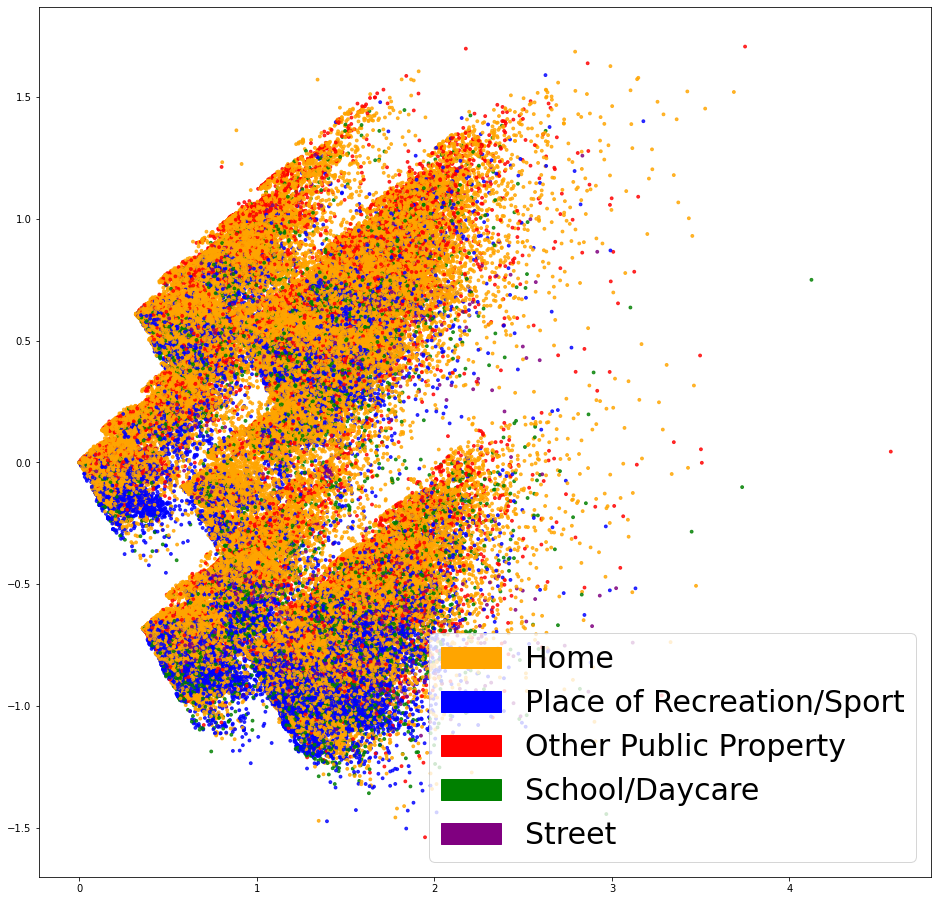

In [16]:
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.patches as mpatches


def plot_LSA(test_data, test_labels, savepath="PCA_demo.csv", plot=True):
        lsa = TruncatedSVD(n_components=2)
        lsa.fit(test_data)
        lsa_scores = lsa.transform(test_data)
        color_mapper = {label:idx for idx,label in enumerate(set(test_labels))}
        color_column = [color_mapper[label] for label in test_labels]
        colors = ['orange','red','blue', 'green', 'purple']
        if plot:
            plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, alpha=.8, c=test_labels, cmap=matplotlib.colors.ListedColormap(colors))
            orange_patch = mpatches.Patch(color='orange', label='Home')
            red_patch = mpatches.Patch(color='red', label='Other Public Property')
            blue_patch = mpatches.Patch(color='blue', label='Place of Recreation/Sport')
            green_patch = mpatches.Patch(color='green', label='School/Daycare')
            purple_patch = mpatches.Patch(color='purple', label='Street')


            plt.legend(handles=[orange_patch, blue_patch, red_patch, green_patch, purple_patch], prop={'size': 30})


fig = plt.figure(figsize=(16, 16))          
plot_LSA(X_train_counts, y_train)
plt.show()

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

clf = LogisticRegression(solver='newton-cg', multi_class='multinomial', n_jobs=-1)
clf.fit(X_train_counts, y_train)
y_predicted_counts = clf.predict(X_valid_counts)

def get_metrics(y_test, y_predicted):  
    # true positives / (true positives+false positives)
    precision = precision_score(y_test, y_predicted, pos_label=None,
                                    average='weighted')             
    # true positives / (true positives + false negatives)
    recall = recall_score(y_test, y_predicted, pos_label=None,
                              average='weighted')
    # harmonic mean of precision and recall
    f1 = f1_score(y_test, y_predicted, pos_label=None, average='weighted')
    # true positives + true negatives/ total
    accuracy = accuracy_score(y_test, y_predicted)
    return accuracy, precision, recall, f1

accuracy, precision, recall, f1 = get_metrics(y_valid, y_predicted_counts)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.904, precision = 0.903, recall = 0.904, f1 = 0.900


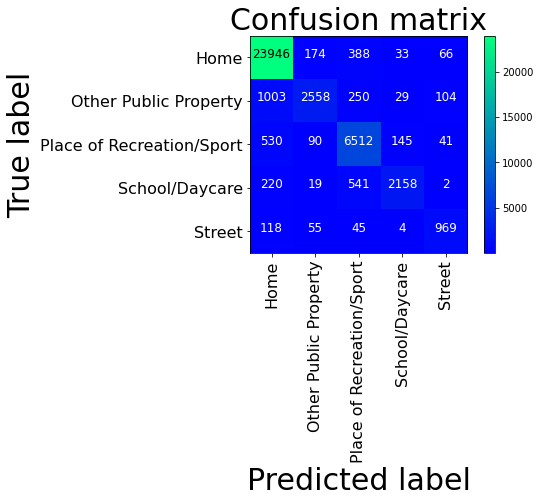

[[23946   174   388    33    66]
 [ 1003  2558   250    29   104]
 [  530    90  6512   145    41]
 [  220    19   541  2158     2]
 [  118    55    45     4   969]]


In [18]:

import numpy as np
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.winter):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=16, rotation=90)
    plt.yticks(tick_marks, classes, fontsize=16)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", 
                 color="white" if cm[i, j] < thresh else "black", fontsize=12)
    
    plt.ylabel('True label', fontsize=30)
    plt.xlabel('Predicted label', fontsize=30)

    return plt

cm = confusion_matrix(y_valid, y_predicted_counts)
plot = plot_confusion_matrix(cm, classes=['Home','Other Public Property',
                                          'Place of Recreation/Sport', 'School/Daycare',
                                          'Street'], 
                             normalize=False, title='Confusion matrix')
plt.show()
print(cm)

In [19]:
def get_most_important_features(vectorizer, model, n=5):
    index_to_word = {v:k for k,v in vectorizer.vocabulary_.items()}
    
    # loop for each class
    classes ={}
    for class_index in range(model.coef_.shape[0]):
        word_importances = [(el, index_to_word[i]) for i,el in enumerate(model.coef_[class_index])]
        sorted_coeff = sorted(word_importances, key = lambda x : x[0], reverse=True)
        tops = sorted(sorted_coeff[:n], key = lambda x : x[0])
        bottom = sorted_coeff[-n:]
        classes[class_index] = {
            'tops':tops,
            'bottom':bottom
        }
    return classes

importance = get_most_important_features(count_vect, clf, 10)
importance

{0: {'tops': [(2.5009476941750726, 'bed'),
   (2.5065285667753017, 'basement'),
   (2.5599575787257782, 'bathtub'),
   (2.6809899286951113, 'video'),
   (2.9712188332340372, 'entertainment'),
   (3.186942736923254, 'porch'),
   (3.574084559121217, 'yard'),
   (3.7841607354607825, 'driveway'),
   (3.9232058484831187, 'home'),
   (3.92465720897059, 'backyard')],
  'bottom': [(-3.2456684648792975, 'park'),
   (-3.2517874888205727, 'playground'),
   (-3.3333800277140093, 'nsg'),
   (-3.3657392412315548, 'school'),
   (-3.411778499071065, 'court'),
   (-3.652749662987713, 'gym'),
   (-3.69148939676699, 'hotel'),
   (-3.8718294174657566, 'daycare'),
   (-5.419314817651841, 'group'),
   (-5.790504379791541, 'nursing')]},
 1: {'tops': [(3.9082546732123458, 'mall'),
   (3.9347097851355155, 'shelter'),
   (3.9841877282216602, 'ecf'),
   (4.1096623165939725, 'store'),
   (4.348898238697978, 'nh'),
   (4.665699819008279, 'nursing'),
   (4.686398614409395, 'jail'),
   (4.754594086455492, 'hotel'),


In [20]:
#try to find way to plot importance

In [21]:
#tfidf
from sklearn.feature_extraction.text import TfidfVectorizer

def tfidf(data):
    tfidf_vect = TfidfVectorizer()

    train = tfidf_vect.fit_transform(data)

    return train, tfidf_vect

X_train_tfidf, tfidf_vect = tfidf(X_train)
X_valid_tfidf = tfidf_vect.transform(X_valid)

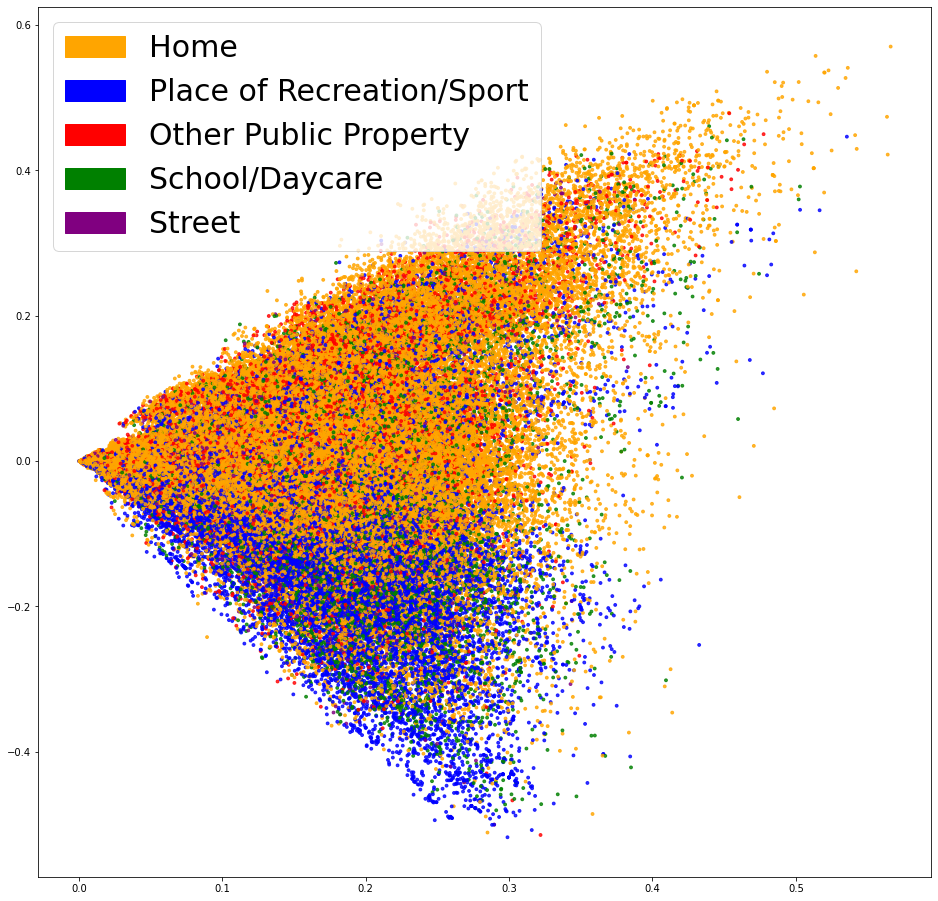

In [22]:
fig = plt.figure(figsize=(16, 16))          
plot_LSA(X_train_tfidf, y_train)
plt.show()

In [23]:
clf_tfidf = LogisticRegression(solver='newton-cg', multi_class='multinomial', n_jobs=-1)
clf_tfidf.fit(X_train_tfidf, y_train)
y_predicted_tfidf = clf_tfidf.predict(X_valid_tfidf)

accuracy_tfidf, precision_tfidf, recall_tfidf, f1_tfidf = get_metrics(y_valid, y_predicted_tfidf)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy_tfidf, precision_tfidf, 
                                                                       recall_tfidf, f1_tfidf))

accuracy = 0.900, precision = 0.901, recall = 0.900, f1 = 0.896


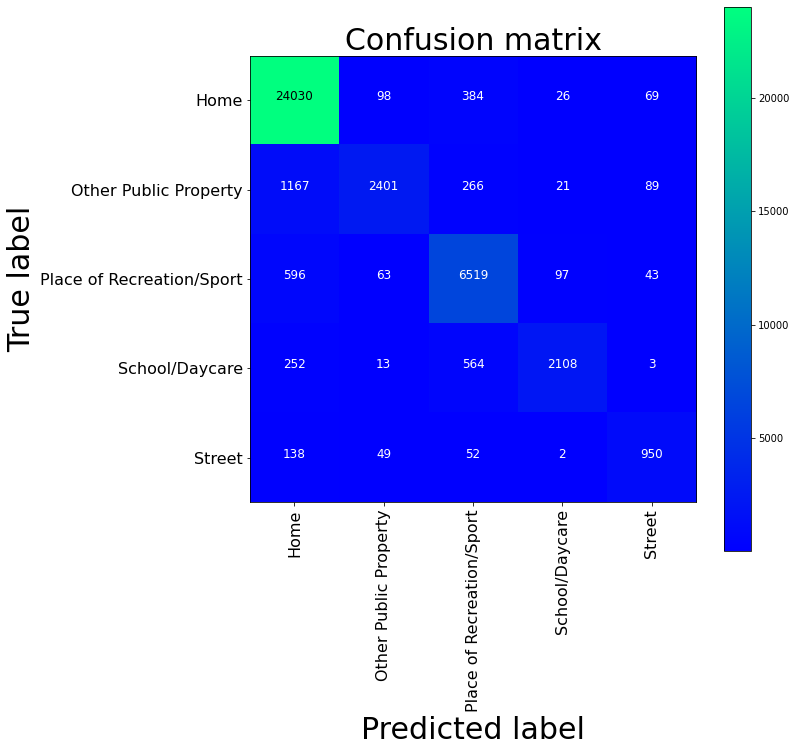

TFIDF confusion matrix
[[24030    98   384    26    69]
 [ 1167  2401   266    21    89]
 [  596    63  6519    97    43]
 [  252    13   564  2108     3]
 [  138    49    52     2   950]]
BoW confusion matrix
[[23946   174   388    33    66]
 [ 1003  2558   250    29   104]
 [  530    90  6512   145    41]
 [  220    19   541  2158     2]
 [  118    55    45     4   969]]


In [24]:
cm2 = confusion_matrix(y_valid, y_predicted_tfidf)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm2, classes=['Home','Other Public Property',
                                          'Place of Recreation/Sport', 'School/Daycare',
                                          'Street'], normalize=False, title='Confusion matrix')
plt.show()
print("TFIDF confusion matrix")
print(cm2)
print("BoW confusion matrix")
print(cm)

In [25]:
importance_tfidf = get_most_important_features(tfidf_vect, clf_tfidf, 10)
importance_tfidf

{0: {'tops': [(5.134945031702186, 'bathtub'),
   (5.281709277201941, 'kitchen'),
   (5.497111456670411, 'backyard'),
   (5.626413466927708, 'shower'),
   (5.8393439549583865, 'house'),
   (6.055901867806315, 'yard'),
   (6.061800198859031, 'porch'),
   (6.12228575358436, 'couch'),
   (8.276495107260294, 'bed'),
   (16.139744708442546, 'home')],
  'bottom': [(-6.727696992245753, 'store'),
   (-6.841233858299839, 'park'),
   (-6.86432554381999, 'playground'),
   (-6.880894065151672, 'class'),
   (-6.968440933251407, 'nh'),
   (-8.38246508179172, 'daycare'),
   (-8.423042912400874, 'group'),
   (-9.288553595075866, 'gym'),
   (-10.689970272780169, 'school'),
   (-13.155397092084277, 'nursing')]},
 1: {'tops': [(7.438507368081366, 'sidewalk'),
   (7.918755433659084, 'group'),
   (8.622460177057148, 'ecf'),
   (8.748731796288082, 'jail'),
   (8.85178887829833, 'restaurant'),
   (8.907997850345279, 'nh'),
   (9.10535998085553, 'hotel'),
   (9.533103306615947, 'church'),
   (9.657557591586608

In [26]:
# plot importance_tfidf

In [27]:
import gensim

# Load Google's pre-trained Word2Vec model.
word2vec_path = "Data\\gensim-data\\word2vec-google-news-300\\word2vec-google-news-300.gz"
word2vec = gensim.models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

c:\Users\StuartWilson\Documents\Portfolio\NEISS\Python\.venv\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [28]:
def get_average_word2vec(tokens_list, vector, generate_missing=False, k=300):
    if len(tokens_list)<1:
        return np.zeros(k)
    if generate_missing:
        vectorized = [vector[word] if word in vector else np.random.rand(k) for word in tokens_list]
    else:
        vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]
    length = len(vectorized)
    summed = np.sum(vectorized, axis=0)
    averaged = np.divide(summed, length)
    return averaged

def get_word2vec_embeddings(vectors, text, generate_missing=False):
    embeddings = text['Tokens_lemma'].apply(lambda x: get_average_word2vec(x, vectors, 
                                                                                generate_missing=generate_missing))
    return list(embeddings)

In [29]:
embeddings = get_word2vec_embeddings(word2vec, sample)
X_train_word2vec, X_valid_word2vec, y_train_word2vec, y_valid_word2vec = train_test_split(embeddings, list_labels, 
                                                                                        test_size=0.2, random_state=40)

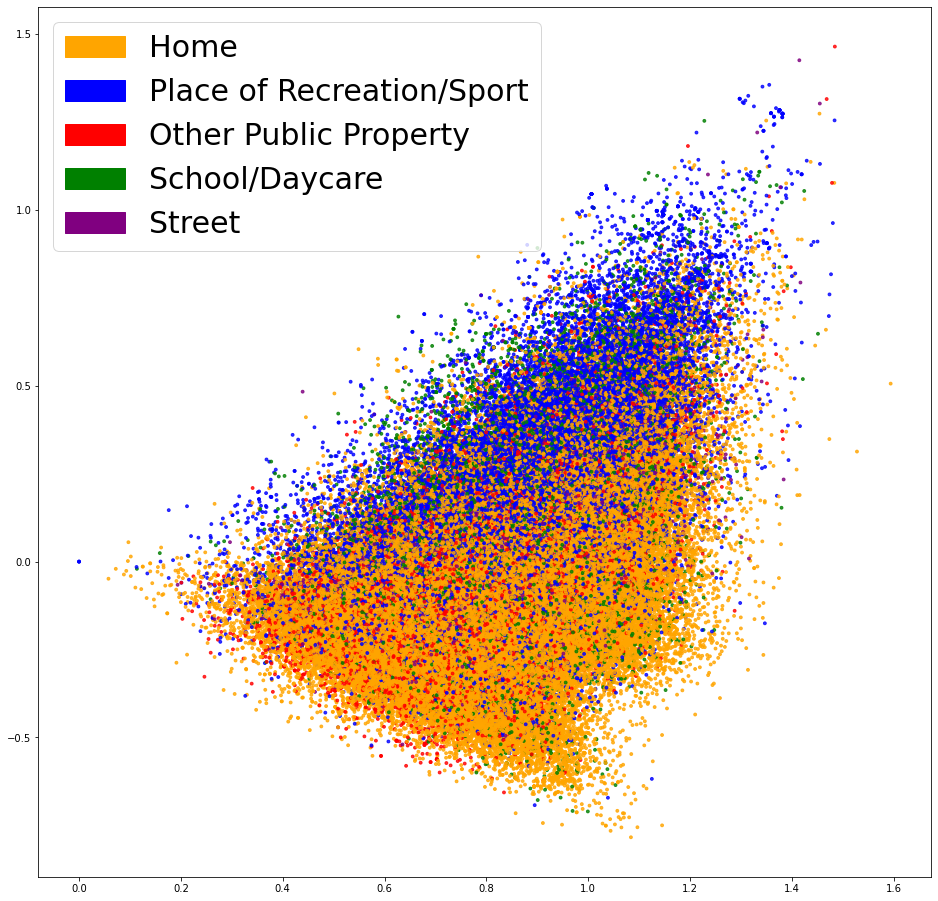

In [30]:
fig = plt.figure(figsize=(16, 16))          
plot_LSA(embeddings, list_labels)
plt.show()

In [31]:
clf_w2v = LogisticRegression(solver='newton-cg', multi_class='multinomial', n_jobs=-1)
clf_w2v.fit(X_train_word2vec, y_train_word2vec)
y_predicted_word2vec = clf_w2v.predict(X_valid_word2vec)

accuracy_word2vec, precision_word2vec, recall_word2vec, f1_word2vec = get_metrics(y_valid_word2vec, y_predicted_word2vec)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy_word2vec, precision_word2vec, 
                                                                       recall_word2vec, f1_word2vec))

accuracy = 0.860, precision = 0.856, recall = 0.860, f1 = 0.852


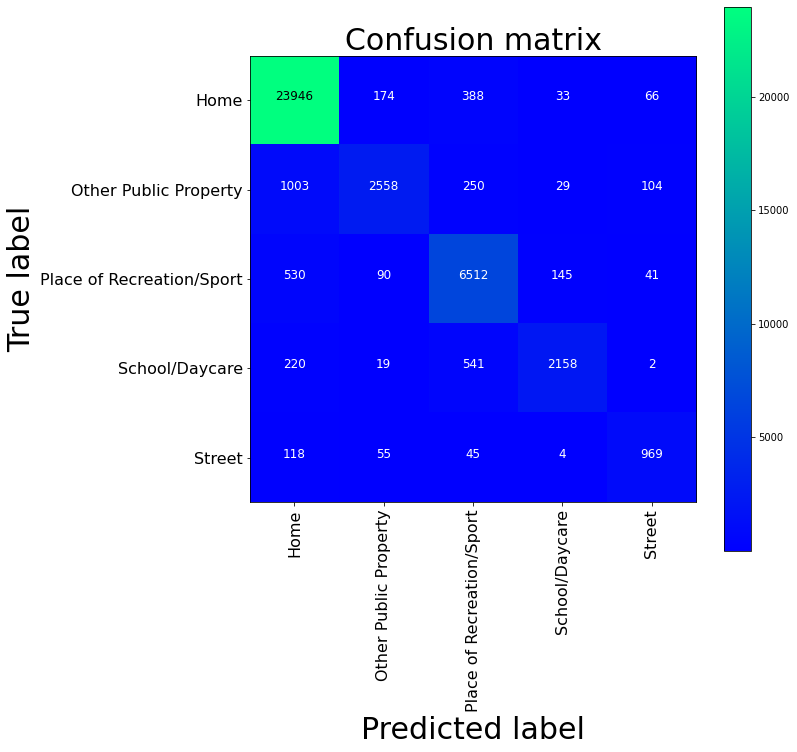

Word2Vec confusion matrix
[[23573   315   493    48    80]
 [ 1680  1804   338    21   102]
 [  828   119  6219   135    56]
 [  338    29   630  1931     3]
 [  228    65    85     6   874]]
TFIDF confusion matrix
[[24030    98   384    26    69]
 [ 1167  2401   266    21    89]
 [  596    63  6519    97    43]
 [  252    13   564  2108     3]
 [  138    49    52     2   950]]
BoW confusion matrix
[[23946   174   388    33    66]
 [ 1003  2558   250    29   104]
 [  530    90  6512   145    41]
 [  220    19   541  2158     2]
 [  118    55    45     4   969]]


In [32]:
cm_w2v = confusion_matrix(y_valid_word2vec, y_predicted_word2vec)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm, classes=['Home','Other Public Property',
                                          'Place of Recreation/Sport', 'School/Daycare',
                                          'Street'], normalize=False, title='Confusion matrix')
plt.show()
print("Word2Vec confusion matrix")
print(cm_w2v)
print("TFIDF confusion matrix")
print(cm2)
print("BoW confusion matrix")
print(cm)

In [33]:
#try word2vec on full dataset because need huge corpus